# TIM - Examen Pratique 2020-2021
## Lundi 18 Janvier 2021

In [1]:
# A compléter
# Importer ici les packages qui vous seront nécessaires pour cette partie de l'examen
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np

# Partie Application : Yves Montand 2.0

Uberoo, célèbre start-up de livraison de repas à vélos, a décidé de régler le problème lié à la polémique de ces travailleurs sous-payés : elle va remplacer ces coursiers par des vélos automatiques !

<img src="../Base_images/Uberoo.jpg" style="width: 300px;"/>

*Vive le capitalisme !*

La start-up nation appelée "L'état français" a approuvée cette jolie initiative à la seule condition que ces vélos automatiques roulent uniquement sur les nombreuses pistes cyclables existantes, indiquées grâce à ce panneau (disponible dans votre base d'images, sous le nom "pattern_piste_cyclable_obligatoire.png").

<img src="../Base_images/pattern_piste_cyclable_obligatoire.png" style="width: 300px;"/>


Face à cette annonce, Uberoo a commencé à implémenter un algorithme qui détecte automatiquement les panneaux sur la route. Cependant, elle n'arrive pas à réaliser la **classification** de ces panneaux. Elle est prête à abandonner l'idée et à payer convenablement ces coursiers.

Votre objectif pour cet exercice est d'éviter cette catastrophe économique que Uberoo s'apprête à subir en payant ces coursiers au SMIC, en créant une fonction qui, à partir d'une image de panneau routier, retournera un booléen qui dira si celui-ci contient un panneau "piste cyclable obligatoire" ou non.

Uberoo nous a pour cela fourni une base de données de xx images (dans le dossier "Panneaux routiers" de votre base d'images).

---
**1)** Quelles sont les opportunités permettant de détecter ce panneau dans une image ?

**_REPONSE :_** 

Le panneau à détecter comporte selon moi trois caractéristiques exploitables :
- Le panneau est en forme de cercle, qui est une forme qui peut être facilement detectée, notamment quand il est bien parfait comme celui-ci ;
- Le fond du panneau est bleu foncé uniforme. Cette couleur peut potentiellement être détectable ;
- Le panneau contient un symbole de vélo, une forme complexe mais assez distinctible dans une image.

---
**2)** Proposez un ou plusieurs outils pour classifier cette image à partir de votre analyse d'opportunités en justifiant vos choix. Choisissez un ou plusieurs de ces outils que vous allez implémenter pour la suite.

**_REPONSE :_**

- Si on décide de détecter les cercles, je propose pour cela d'utiliser l'algorithme de Hough pour la détection de cercles. Cela permettra déjà de détecter uniquement les panneaux ronds, en éliminant certains ;
- Si on décide de détecter le fond bleu foncé, je propose pour cela d'utiliser la sélection de couleur après conversion de notre image en HSV. En fonction du masque obtenu, on pourra ensuite déterminer s'il y a un panneau piste cyclable obligatoire ou non
- Et si on décide de détecter le symbole de vélo, on peut utiliser un algorithme de détection de points d'intérêts puis de matching de ces points, tels que SIFT ou ORB. En fonction du nombre de points matchés, on pourra déterminer si l'image contient un panneau piste cyclable obligatoire ou non.

---
**3)** Implémentez votre ou vos propositions de classification de panneaux routiers. Cette fonction prendra en entrée une image de panneau routier et retournera au minimum un booléen qui indique la présence ou non de panneau "piste cyclable obligatoire").

*Conseils :* 
- Svp décrivez votre démarche à l'écrit. Chercher à comprendre ce que vous proposez en code, c'est compliqué...
- Ce n'est pas grave si votre fonction ne classifie pas parfaitement, tant que l'emploi de celle-ci est justifiée : un résultat qui n'est pas concluant reste un résultat ;
- Mettez des commentaires dans votre code ! 
- Il est fortement conseillé d'afficher des résultats intermédiaires dans votre fonction, pour justifier le bon fonctionnement de celle-ci ;
- Uberoo déteste l'idée d'utiliser un réseau de neurones pour la classification. Elle considère que ce sont des boites noires magiques et que ça ne vaut pas un bon petit filtre de Canny-Deriche...

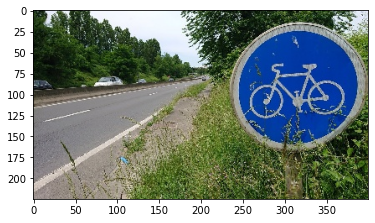

In [2]:
# Chargement d'une image de panneau routier pour tester nos algorithmes
img = cv2.cvtColor(cv2.imread("../Base_images/Panneaux/8.jpg",1),cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

Nombre de cercles détectés : 1


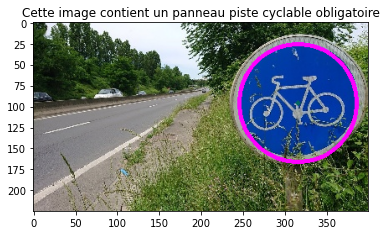

In [3]:
## Classification via détection de cercles avec Hough
# On considère ici que notre image contient un panneau piste cyclable obligatoire s'il détecte au moins un cercle dans l'image. 
# Cela permettra d'éliminer déjà les images sans panneau rond.
def hough_classification(image,show=True):
    # Si notre image est une image couleur à 3 dimensions, on la passe à 2 dimensions en la convertissant en niveaux de gris
    if image.ndim == 3:
        img1=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        output = image.copy()

    rows = img1.shape[0]

    # Avant de détecter les possibles cercles, on applique d'abord un filtre médian de taille 5X5
    img1 = cv2.medianBlur(img1, 5)
    
    # Détection des cercles vi Hough. Les paramètres ont été définis après plusieurs tests réalisés sur la base d'images
    circles = cv2.HoughCircles(img1, cv2.HOUGH_GRADIENT, 1, rows / 8,
                                   param1=200, param2=60,
                                   minRadius=20, maxRadius=200)
    # On affiche le nombre de cercles détectés
    if show:
        print("Nombre de cercles détectés : {}".format(circles.shape[1] if circles is not None else 0))
    
    # On trace les cercles détectés sur l'image pour vérifier
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            center = (i[0], i[1])
            cv2.circle(output, center, 1, (0, 100, 100), 3)
            radius = i[2]
            cv2.circle(output, center, radius, (255, 0, 255), 3)
    if show:
        plt.imshow(output)
        if circles is not None:
            plt.title("Cette image contient un panneau piste cyclable obligatoire")
        else:
            plt.title("Cette image ne contient pas de panneau piste cyclable obligatoire")
        plt.show()
    return circles is not None, output

__,__ = hough_classification(img,show=True)

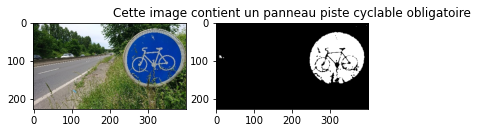

In [4]:
## Classification via sélection de couleur bleu foncé sur l'image convertie en HSV.
# On considère ici que notre image contient un panneau piste cyclable obligatoire si on a un nombre suffisant de pixels bleu foncé (10 %) 
# Cela permettra d'éliminer les images sans panneau bleu.
def blue_selection_classification(image,show=True):
    # Conversion de l'image RGB en HSV
    hsv_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    
    # Sélection de la couleur bleu. 
    # Les valeurs de sélection ont été définies à la main après plusieurs tests sur la base de données de panneaux routiers.
    lower_blue = np.array([107,50,50])
    upper_blue = np.array([140,255,255])
    mask = cv2.inRange(hsv_image, lower_blue, upper_blue).astype(np.bool)

    # Affichage du masque obtenu
    if show:
        plt.subplot(121)
        plt.imshow(image)
        plt.subplot(122)
        plt.imshow(mask,'gray')
        if (np.sum(mask)/mask.size)>0.1:
            plt.title("Cette image contient un panneau piste cyclable obligatoire")
        else:
            plt.title("Cette image ne contient pas un panneau piste cyclable obligatoire")
        plt.show()
    return (np.sum(mask)/mask.size)>0.1,mask
__,__ = blue_selection_classification(img,show=True)

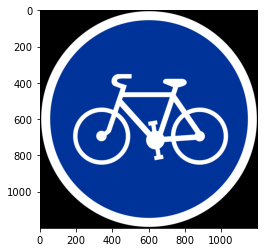

In [5]:
# Chargement du pattern pour la 3ème proposition de classification
pattern = cv2.cvtColor(cv2.imread("../Base_images/pattern_piste_cyclable_obligatoire.png",1),cv2.COLOR_BGR2RGB)
plt.imshow(pattern)

In [6]:
pattern=cv2.resize(pattern,(200,200))

In [7]:
pattern.shape

(200, 200, 3)

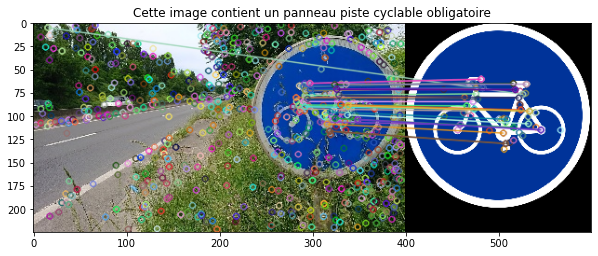

In [8]:
## Classification via détection et matching de points d'intérêts entre l'image originale et le pattern à détecter avec SIFT.
# On considère ici que notre image contient un panneau piste cyclable obligatoire si on a au moins 10 connexions réalisées entre 
# les points d'intérêts détectés sur l'image originale et le pattern.
# Cela permettra d'éliminer les images qui ne contiennent pas de panneaux avec le symbole vélo.
MIN_MATCH_COUNT=10

def SIFT_matching_classification(image,pattern,show=True):
    # Conversion de l'image et du pattern en niveaux de gris
    img1 = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    img2 = cv2.cvtColor(pattern,cv2.COLOR_RGB2GRAY)

    # Initialisation du détecteur SIFT
    sift = cv2.SIFT_create()
    # Détection des points d'intérêts sur les deux images avec SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    # Matching des points d'intérêts avec l'algorithme FLANN
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # On considère que les matchings sont bons si la distance entre les points est assez proche
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
    
    # Affichage des matchings trouvés entre les points détectés de l'image originale et du pattern

    matchesMask = None
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

    output = cv2.drawMatches(image,kp1,pattern,kp2,good,None)
    if show:
        plt.subplots(1,1,figsize=(10,10))
        if len(good)>MIN_MATCH_COUNT:
            plt.title("Cette image contient un panneau piste cyclable obligatoire")
        else:
            plt.title("Cette image ne contient pas un panneau piste cyclable obligatoire")
        plt.imshow(output, 'gray'),plt.show()
    return len(good)>MIN_MATCH_COUNT,output

__,__=SIFT_matching_classification(img,pattern,show=True)

---
**4)** Appliquer votre fonction sur toutes les images de panneaux routiers de la base de données, avec le résultat de votre fonction de classification.

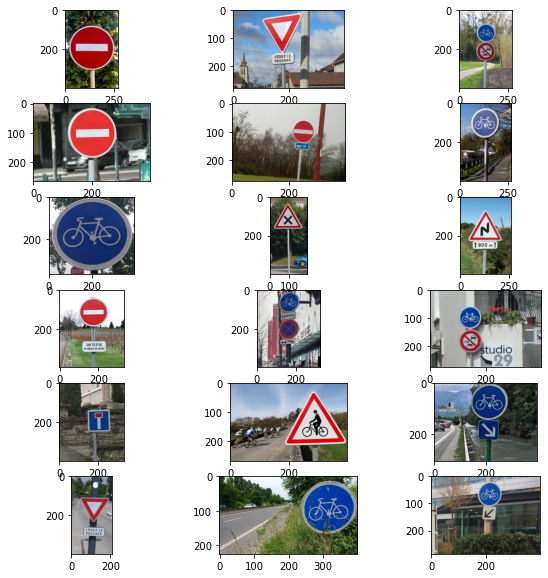

In [9]:
# Import et affichage des images de la base de données de panneaux
panneaux = [cv2.cvtColor(cv2.imread('../Base_images/Panneaux/'+filename,1),cv2.COLOR_BGR2RGB) for filename in os.listdir('../Base_images/Panneaux/')]
plt.subplots(6,3,figsize=(10,10))
for i,panneau in enumerate(panneaux):
    plt.subplot(6,3,i+1)
    plt.imshow(panneau)
plt.show()

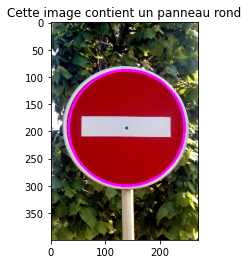

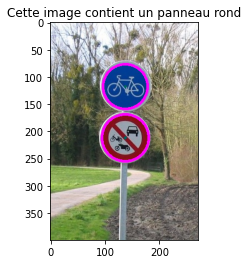

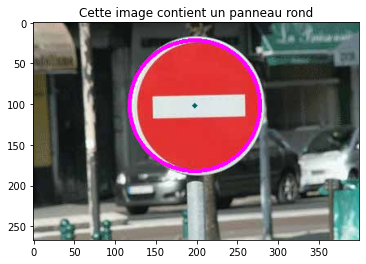

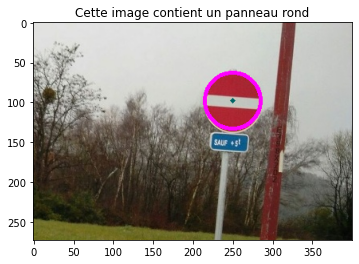

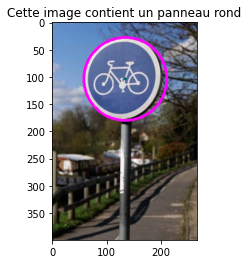

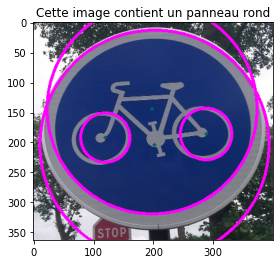

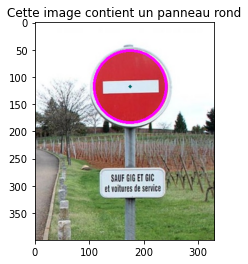

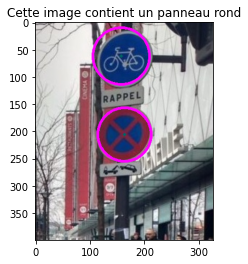

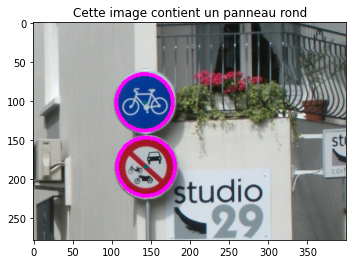

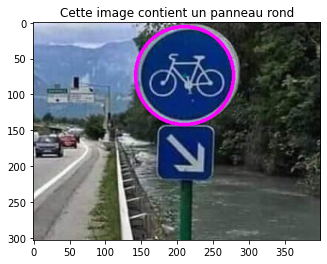

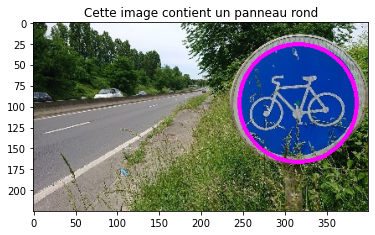

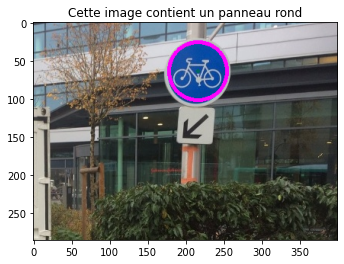

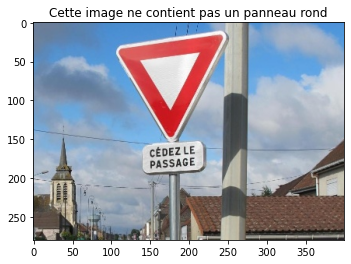

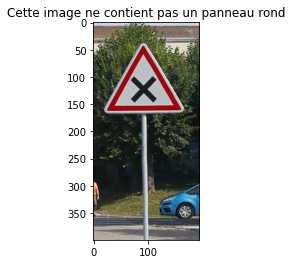

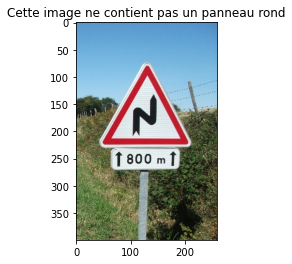

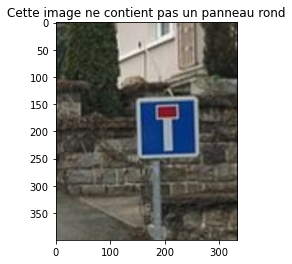

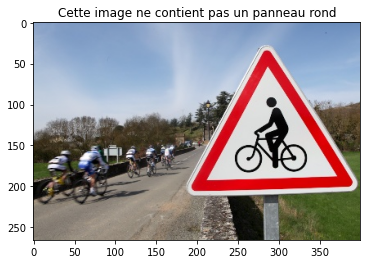

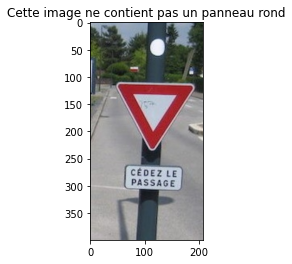

In [10]:
# Test de notre classification via Hough
image_avec_panneau_cycle = []
image_sans_panneau_cycle = []

for panneau in panneaux:
    detect_circle, output = hough_classification(panneau,show=False)
    if detect_circle:
        image_avec_panneau_cycle.append(output)
    else:
        image_sans_panneau_cycle.append(output)

for panneau in image_avec_panneau_cycle:
    plt.imshow(panneau)
    plt.title("Cette image contient un panneau rond")
    plt.show()

for panneau in image_sans_panneau_cycle:
    plt.imshow(panneau)
    plt.title("Cette image ne contient pas un panneau rond")
    plt.show()

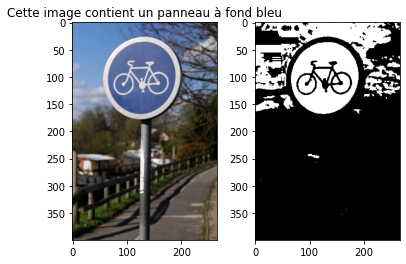

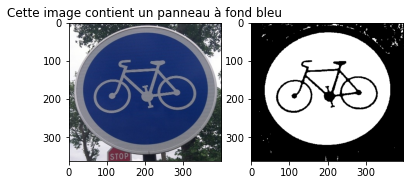

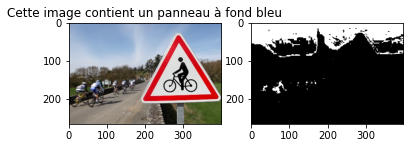

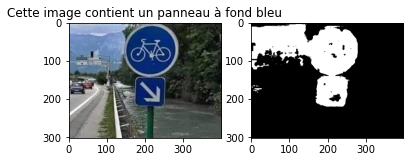

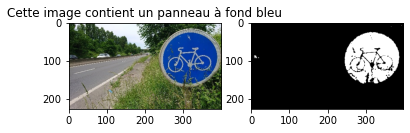

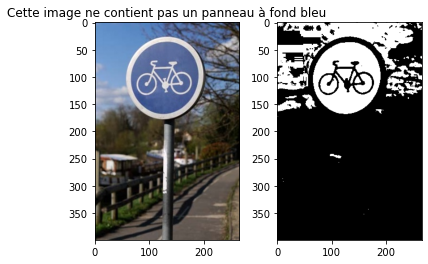

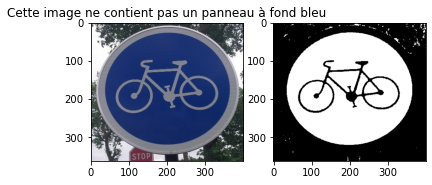

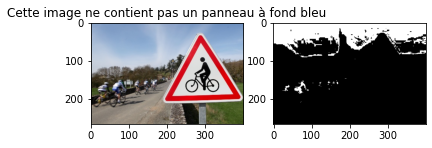

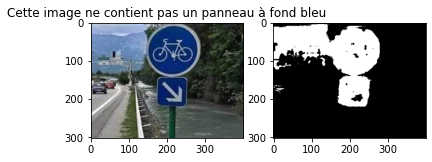

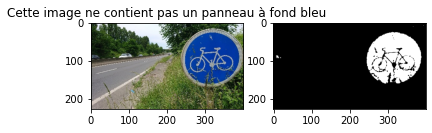

In [11]:
# Test de notre classification via Sélection de couleurs HSV
image_avec_panneau_cycle = []
image_sans_panneau_cycle = []

for panneau in panneaux:
    blue_detected, output = blue_selection_classification(panneau,show=False)
    if blue_detected:
        image_avec_panneau_cycle.append([panneau,output])
    else:
        image_sans_panneau_cycle.append([panneau,output])

for [panneau,mask] in image_avec_panneau_cycle:
    plt.subplot(121)
    plt.imshow(panneau)
    plt.title("Cette image contient un panneau à fond bleu")
    plt.subplot(122)
    plt.imshow(mask,'gray')
    plt.show()

for [panneau,mask] in image_avec_panneau_cycle:
    plt.subplot(121)
    plt.imshow(panneau)
    plt.title("Cette image ne contient pas un panneau à fond bleu")
    plt.subplot(122)
    plt.imshow(mask,'gray')
    plt.show()

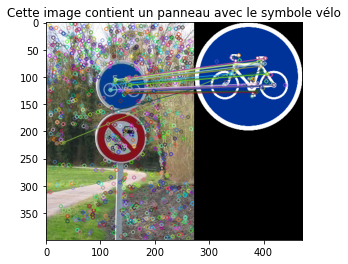

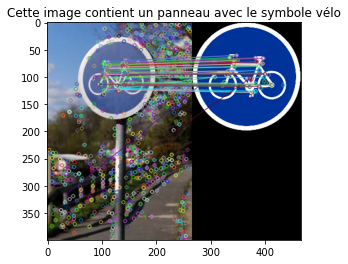

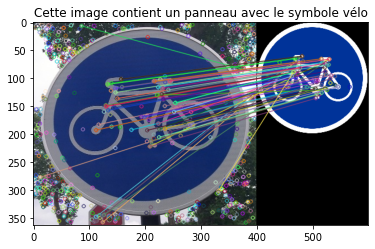

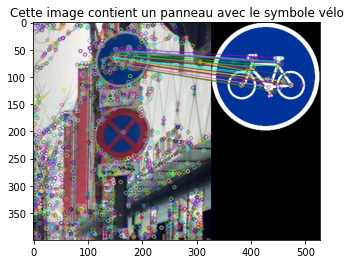

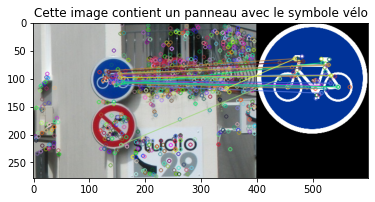

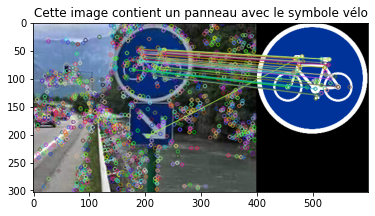

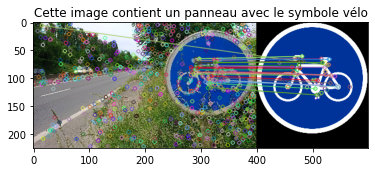

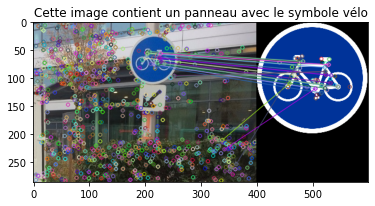

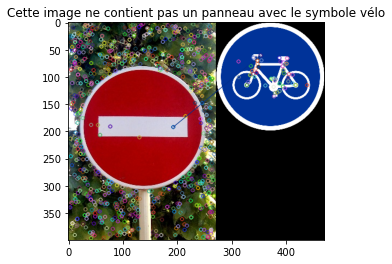

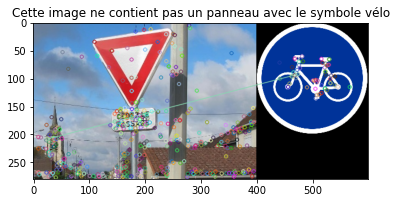

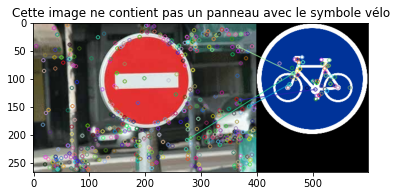

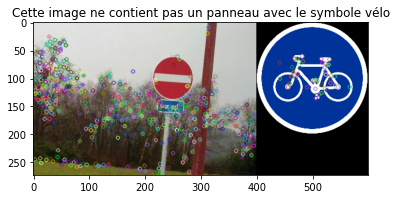

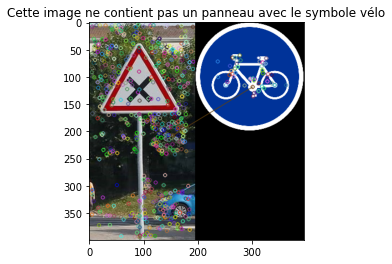

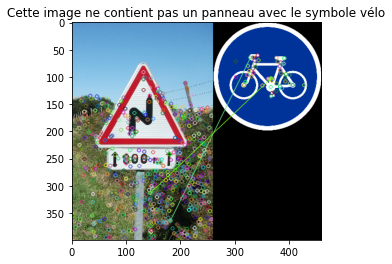

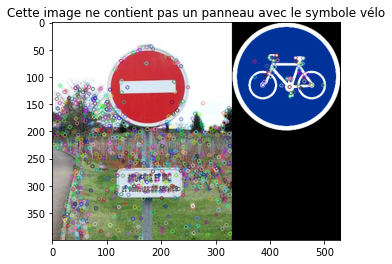

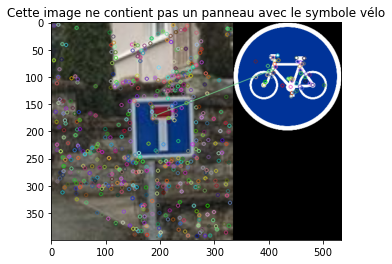

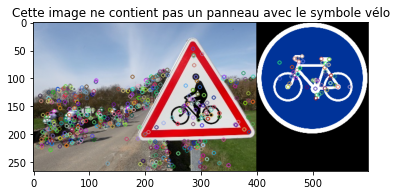

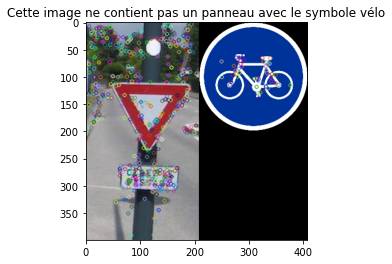

In [12]:
# Test de notre classification via matching avec SIFT & FLANN
image_avec_panneau_cycle = []
image_sans_panneau_cycle = []

for panneau in panneaux:
    detect_velo, output = SIFT_matching_classification(panneau,pattern,show=False)
    if detect_velo:
        image_avec_panneau_cycle.append(output)
    else:
        image_sans_panneau_cycle.append(output)

for panneau in image_avec_panneau_cycle:
    plt.imshow(panneau)
    plt.title("Cette image contient un panneau avec le symbole vélo")
    plt.show()

for panneau in image_sans_panneau_cycle:
    plt.imshow(panneau)
    plt.title("Cette image ne contient pas un panneau avec le symbole vélo")
    plt.show()

---
**5)** Analysez le(s) résultat(s) obtenu(s). N'oubliez pas de comparer les résultats des différentes méthodes (si vous en avez implémenté plusieurs)

**_REPONSE :_**

- La classification via détection de cercles fonctionne partiellement. Les résultats sont corrects (la majorité des panneaux ronds sont détectés, et ceux d'autres formes ne sont pas détectés), malgré quelques fausses détections. Cependant, cette classification a quelques limites : il nous faut pour cela un cercle parfait, donc la prise de vue doit être bien en face du panneau pour que la détection de cercle fonctionne. De plus, ce classifieur ne détectera uniquement que les panneaux ronds, sans savoir si celui-ci est un panneau piste cyclable obligatoire. C'est une piste intéressante à explorer, mais il faut plus de travail dessus.
- La classification via détection de bleu foncé est peu efficace : le panneau étant dans un environnement urbain, le ciel est facilement détecté avec le panneau, ce qui rend le masque difficilement exploitable. De plus, notre indicateur est peu efficace, puisque la taille du panneau ne dépend pas de la taille de l'image, donc définir un ratio est incohérent.
- La classification via matching de points d'intérêts avec SIFT est en revanche très efficace, puisque nous obtenons aucune erreur ! Il y a une nette différence en terme de nombre de matchs réalisés entre les images avec panneau piste cyclable obligatoire et ceux sans.

---
**6)** Selon les résultats obtenus, vos choix étaient-ils adaptés à la problématique ? Pourquoi ? Comment pourrait-on améliorer les résultats ?

**_REPONSE :_**

- Les choix de Hough et sélection de couleur via HSV sont améliorables, en les combinant. En effet, on pourrait améliorer nettement les résultats en détectant d'abord les panneaux ronds avec Hough, puis vérifier que ceux-ci sont majoritairement bleus avec la sélection de couleurs. Cependant, il faudrait d'autres vérifications car il existe d'autres panneaux ronds à fond bleu. Enfin, pour un panneau pris d'un autre angle de vue, ces méthodes combinées restent limitées. Il est pour cela plus intéressant de détecter en particulier le symbole vélo.
- Le choix de matching de point d'intérêts avec SIFT & FLANN était le plus adapté, car les résultats sont très bons sur ce petit ensemble. Il faudra cependant confirmer les résultats avec plus de panneaux, pris sous différents angles avec différents niveaux de luminosité, afin de 

---
## Rendu
Le rendu qui vous est demandé est le notebook.  Vous le déposerez en fin d'examen sur Moodle, dans un dépot prévu à cet effet, dans le format NOM_Prenom_P2.ipynb 